# KE5108 Time Series Forecasting

## Load Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Load Data

In [2]:
train_ts_df = pd.read_csv('data/transformedTrainRatings.csv', index_col=0, parse_dates=True)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792


In [3]:
test_ts_df = pd.read_csv('data/transformedTestRatings.csv', index_col=0, parse_dates=True)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024
2008-07-20,57,20-Jul-2008 (30),216.19,1.678215


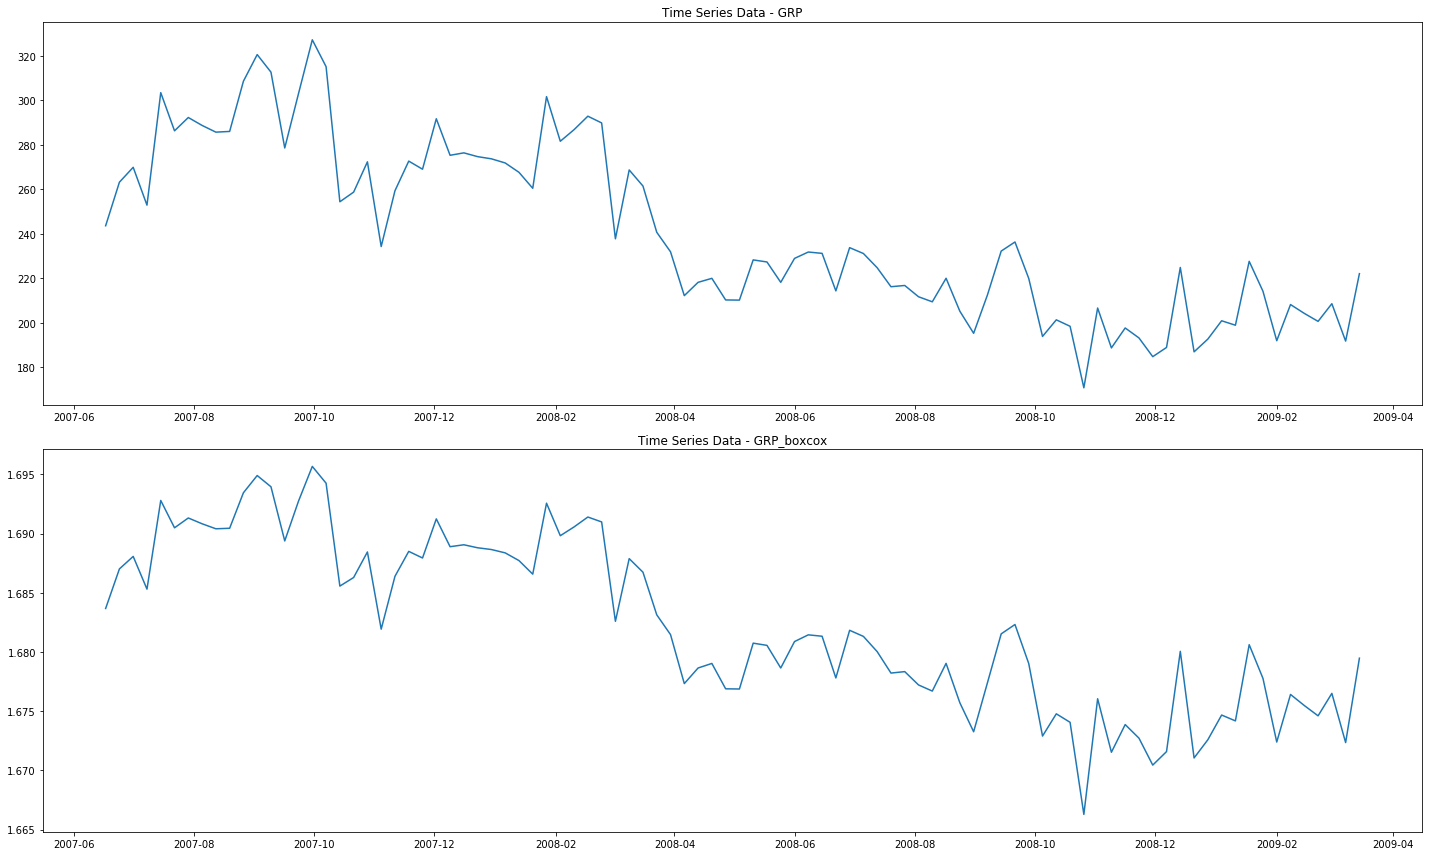

In [4]:
a_df = train_ts_df.append(test_ts_df)
plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.plot(a_df['GRP'])
plt.title("Time Series Data - GRP")
plt.subplot(212)
plt.plot(a_df['GRP_boxcox'])
plt.title("Time Series Data - GRP_boxcox")
plt.tight_layout()
plt.show()

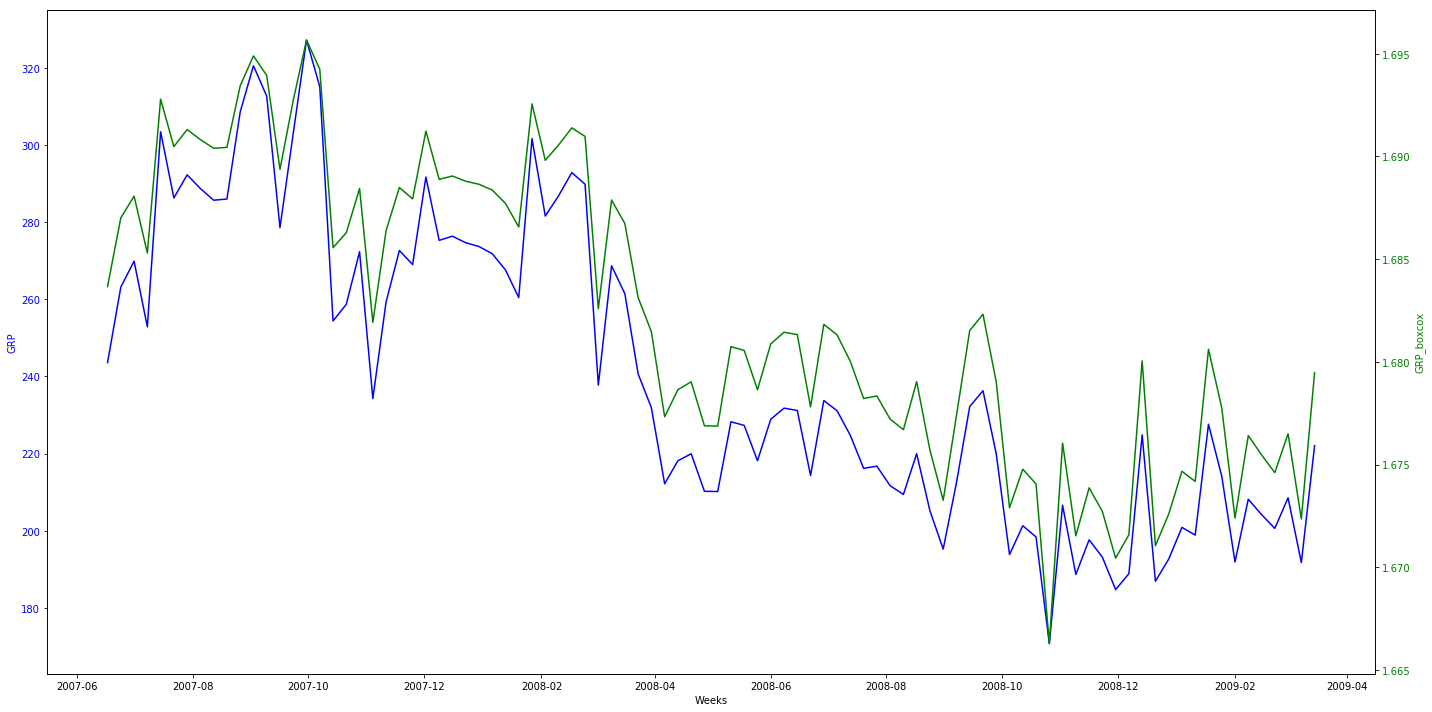

In [5]:
a_df = train_ts_df.append(test_ts_df)
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)

ax1.set_xlabel('Weeks')
ax1.set_ylabel('GRP', color='blue')
ax1.plot(a_df['GRP'], color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'green'
ax2.set_ylabel('GRP_boxcox', color='green')  # we already handled the x-label with ax1
ax2.plot(a_df['GRP_boxcox'], color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Classical Decomposition Method

In [6]:
# Plots the trend, seasonal and residual of the decomposition method.
def plot_decomp(ts_df, freq, model='multiplicative', two_sided=False):
    decomp = sm.tsa.seasonal_decompose(ts_df, model=model, two_sided=two_sided, freq=freq)
    fig = decomp.plot()
    fig.set_size_inches(15, 7)
    fig.get_axes()[0].set_title('Seasonal Frequency of ' + str(freq) + ' Periods')
    plt.show()
    return decomp

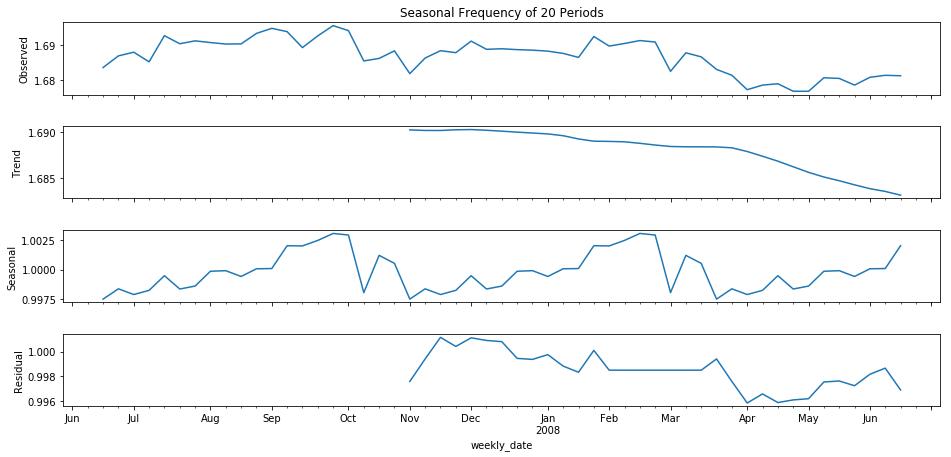

In [7]:
# Number of time series periods in a season = 20 (weeks) or 5 months
decomp20 = plot_decomp(train_ts_df['GRP_boxcox'], freq=20)

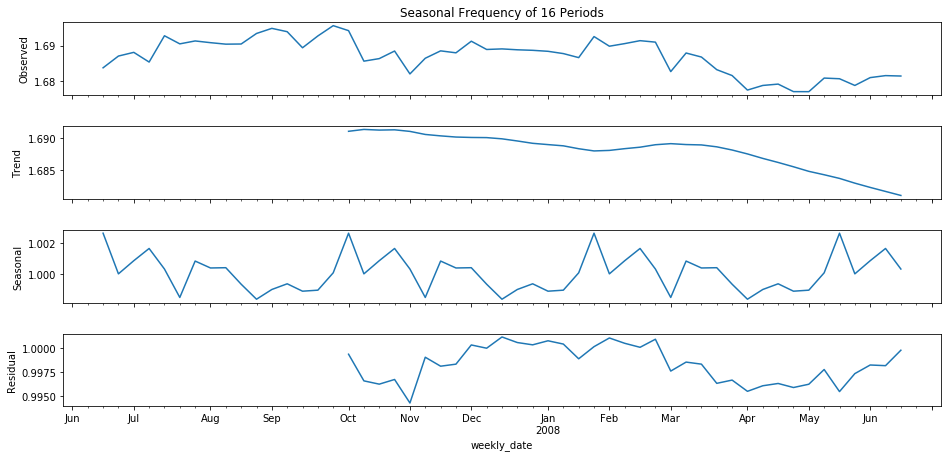

In [8]:
# Number of time series periods in a season = 16 (weeks) or 4 months
decomp16 = plot_decomp(train_ts_df['GRP_boxcox'], freq=16)

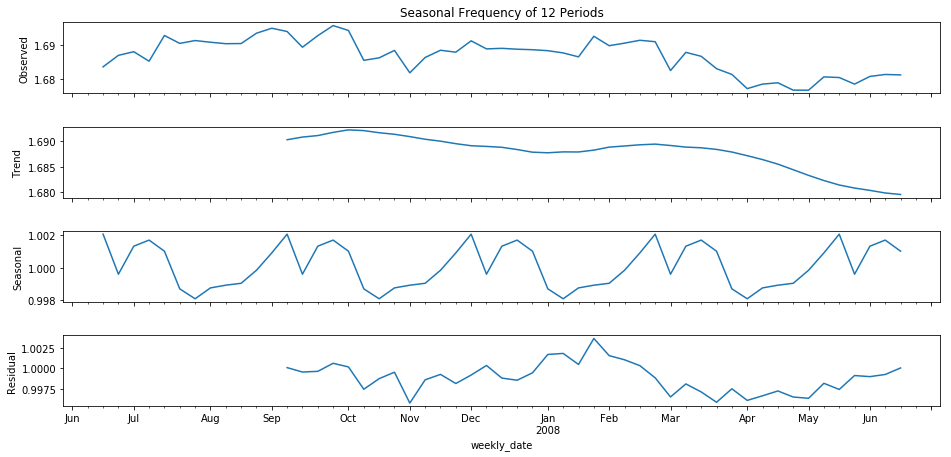

In [9]:
# Number of time series periods in a season = 12 (weeks) or 3 months
decomp12 = plot_decomp(train_ts_df['GRP_boxcox'], freq=12)

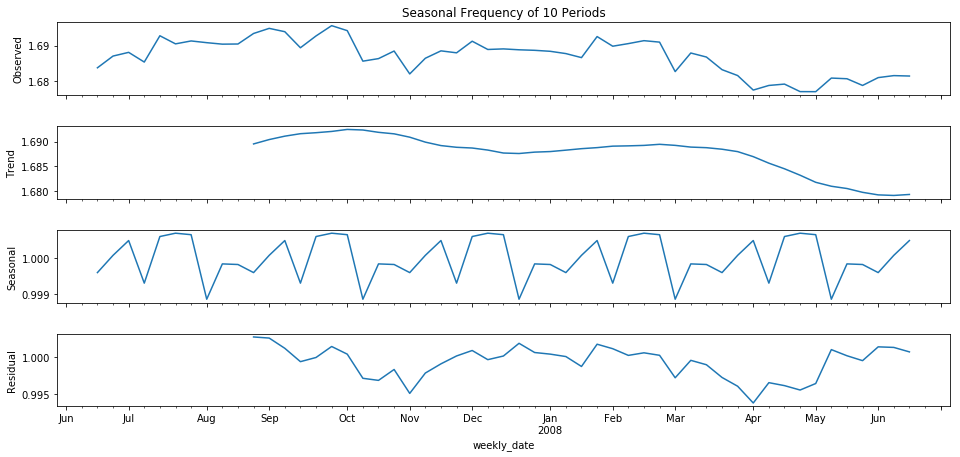

In [10]:
# Number of time series periods in a season = 10 (weeks) or 2.5 months
decomp10 = plot_decomp(train_ts_df['GRP_boxcox'], freq=10)

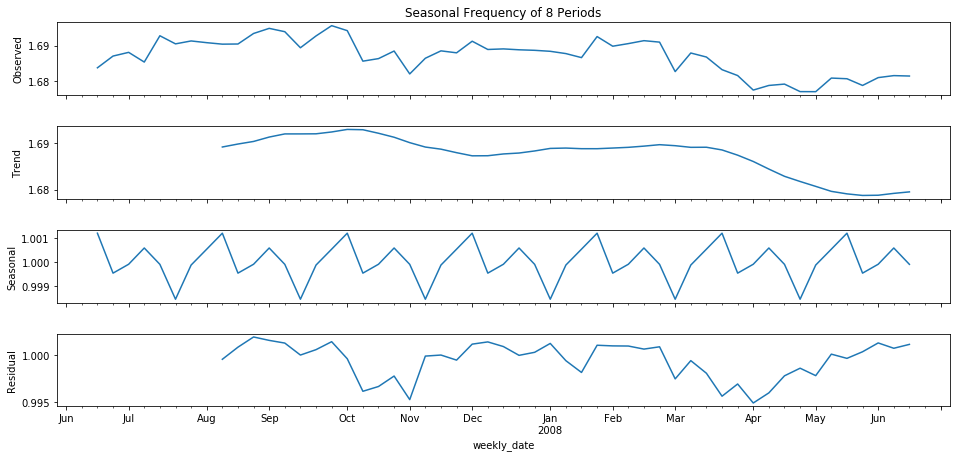

In [11]:
# Number of time series periods in a season = 8 (weeks) or 2 months
decomp8 = plot_decomp(train_ts_df['GRP_boxcox'], freq=8)

### Analysis of Residuals

In [12]:
def plot_residuals(resid, isMult=True, deg=3, title='Residuals by Week'):

    a_resid = resid.copy()
    a_resid.reset_index(drop=True, inplace=True)
    a_resid.dropna(inplace=True)
    idx = a_resid.index.values.reshape(-1, 1)
    
    poly_reg = Pipeline(
        [
            ('poly', PolynomialFeatures(degree=deg)),
            ('linear', LinearRegression(fit_intercept=True))])
    poly_reg.fit(idx, a_resid)
    poly_reg_pred = poly_reg.predict(idx)
    plt.title(title)
    plt.scatter(idx, a_resid, color='black', marker='o', label='residuals', facecolors='none')
    plt.plot(idx, a_resid, color='black', linewidth=1, label='residuals curve', alpha=.5)
    plt.plot(idx, poly_reg_pred, color='blue', linewidth=3, label='regression line')
    if isMult:
        plt.axhline(1)
    else:
        plt.axhline(1)        
    plt.legend()
    return None

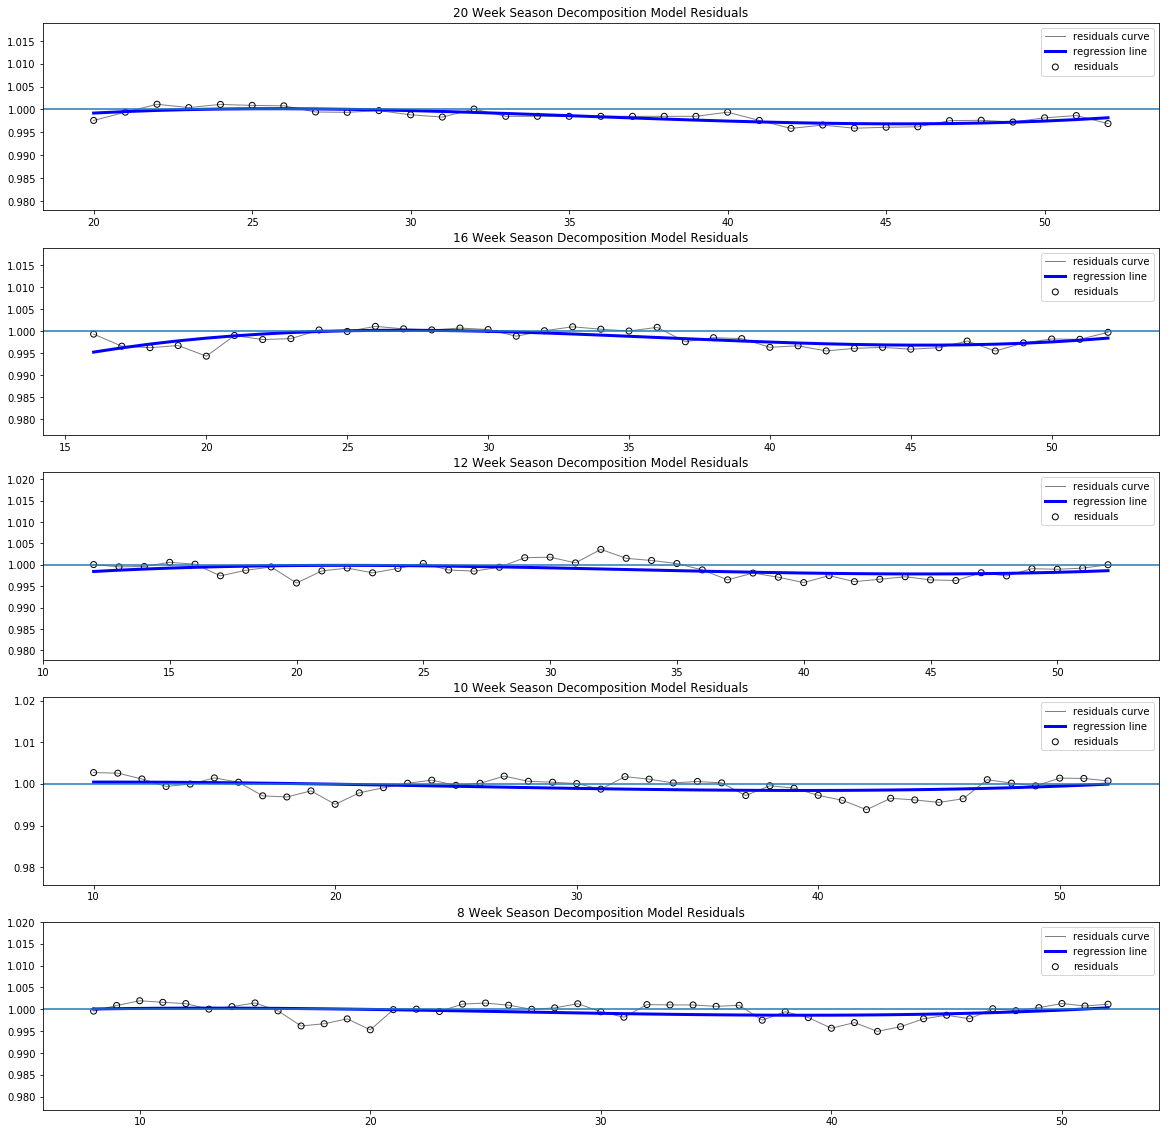

In [13]:
decomp_list = [[decomp20, 20], [decomp16, 16], [decomp12, 12], [decomp10, 10], [decomp8, 8]]
fig, ax = plt.subplots(nrows=len(decomp_list), ncols=1, figsize=(20, 20))
for idx, row in enumerate(ax):
    plt.sca(row)
    plot_residuals(decomp_list[idx][0].resid, isMult=True, deg=3, title=str(decomp_list[idx][1])+' Week Season Decomposition Model Residuals')
plt.show()

### Training / Test Results

20 Week Season Model

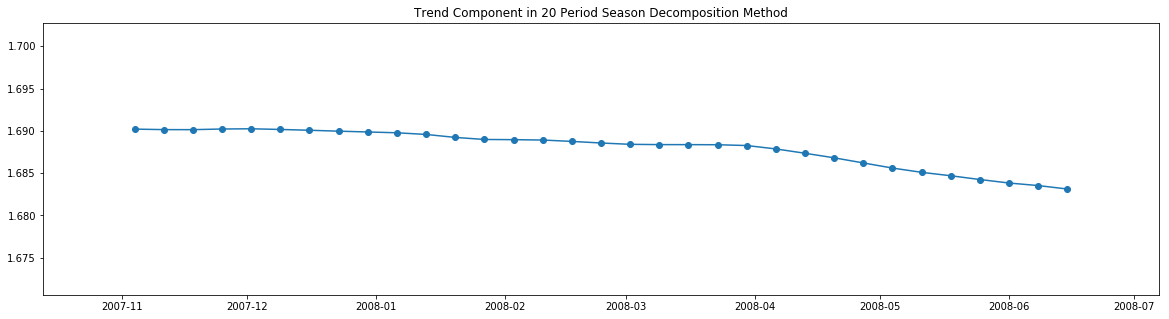

In [14]:
plt.figure(figsize=(20, 5))
plt.scatter(decomp20.trend.index, decomp20.trend.values)
plt.plot(decomp20.trend)
plt.title('Trend Component in 20 Period Season Decomposition Method')
plt.show()

In [15]:
a_trend = decomp20.trend.copy()
a_trend.reset_index(drop=True, inplace=True)
a_trend.dropna(inplace=True)
idx = a_trend.index.values.reshape(-1, 1)
trend_reg = LinearRegression()
# trend_reg = Pipeline(
#     [
#         ('poly', PolynomialFeatures(degree=2)),
#         ('linear', LinearRegression(fit_intercept=True))])
trend_reg.fit(idx, a_trend.values)
train_ts_df['trend'] = trend_reg.predict(train_ts_df['week'].values.reshape(-1, 1))

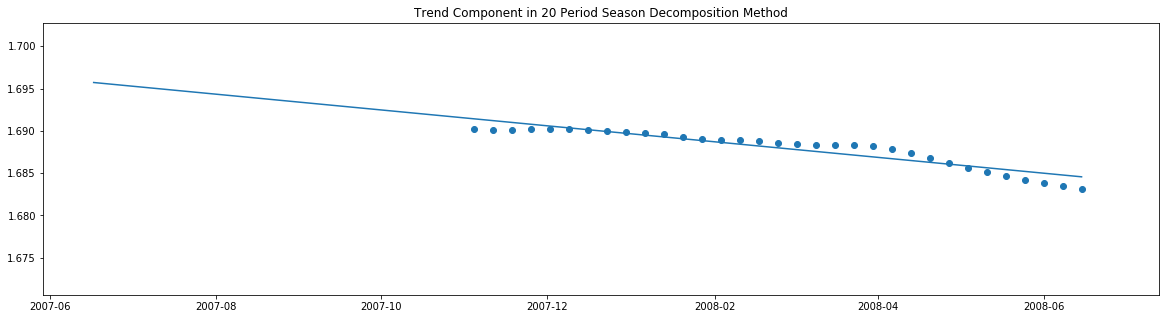

In [16]:
plt.figure(figsize=(20, 5))
plt.scatter(decomp20.trend.index, decomp20.trend.values)
plt.plot(train_ts_df['trend'])
#plt.scatter(decomp20.trend.index.values.reshape(-1, 1), trend_reg.predict(decomp20.trend.index.values.reshape(-1, 1)))
plt.title('Trend Component in 20 Period Season Decomposition Method')
plt.show()

In [17]:
BOXCOX_LAMBDA = -0.5677106

train_ts_df['seasonal'] = decomp20.seasonal
train_ts_df['decomp20'] = inv_boxcox(train_ts_df['trend'] * train_ts_df['seasonal'], BOXCOX_LAMBDA)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,trend,seasonal,decomp20
weekly_date,,,,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670,1.695709,0.997494,293.358003
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012,1.695494,0.998366,302.927292
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067,1.695280,0.997882,295.064849
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303,1.695066,0.998236,297.958225
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792,1.694851,0.999480,312.846197


In [18]:
test_ts_df['trend'] = trend_reg.predict(test_ts_df['week'].values.reshape(-1, 1))

In [19]:
a_seasonal = decomp20.seasonal[:20]
test_ts_df['seasonal'] = [a_seasonal[i] for i in test_ts_df['week'] % 20]
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,trend,seasonal
weekly_date,,,,,,
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804,1.684353,1.002005
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827,1.684138,1.002472
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312,1.683924,1.003063
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024,1.683710,1.002929
2008-07-20,57,20-Jul-2008 (30),216.19,1.678215,1.683496,0.998044


In [20]:
test_ts_df['decomp20'] = inv_boxcox(test_ts_df['trend'] * test_ts_df['seasonal'], BOXCOX_LAMBDA)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,trend,seasonal,decomp20
weekly_date,,,,,,,
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804,1.684353,1.002005,267.723907
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827,1.684138,1.002472,271.415702
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312,1.683924,1.003063,276.593771
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024,1.683710,1.002929,273.652867
2008-07-20,57,20-Jul-2008 (30),216.19,1.678215,1.683496,0.998044,225.589751


In [21]:
train_mse = mean_squared_error(train_ts_df['GRP'].values, train_ts_df['decomp20'].values)
train_rmse = np.sqrt(train_mse)
train_mape = np.sum(np.abs(train_ts_df['GRP'].values - train_ts_df['decomp20'].values) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
test_mse = mean_squared_error(test_ts_df['GRP'].values, test_ts_df['decomp20'].values)
test_rmse = np.sqrt(test_mse)
test_mape = np.sum(np.abs(test_ts_df['GRP'].values - test_ts_df['decomp20'].values) / test_ts_df['GRP'].values) / len(test_ts_df['GRP'].values) * 100

print('train mse = %f\ntrain rmse = %f\ntrain mape = %f\ntest mse = %f\ntest rmse = %f\ntest mape = %f\n'
      % (train_mse, train_rmse, train_mape, test_mse, test_rmse, test_mape))

train mse = 581.305910
train rmse = 24.110286
train mape = 7.877531
test mse = 916.258649
test rmse = 30.269765
test mape = 11.908243



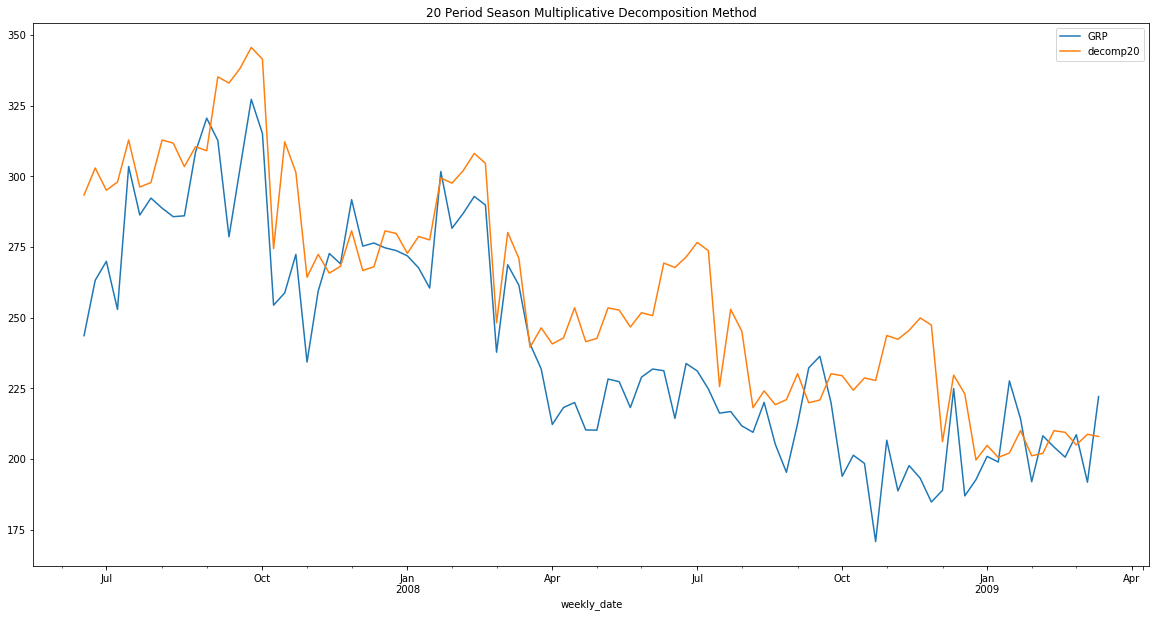

In [22]:
new_ts_df = train_ts_df.append(test_ts_df)
new_ts_df[['GRP', 'decomp20']].plot(figsize=(20, 10), title="20 Period Season Multiplicative Decomposition Method")

### Analysis of Residuals

In [23]:
my_df = train_ts_df.dropna()
residuals = my_df['GRP'].values - my_df['decomp20']
residuals[:10]

weekly_date
2007-06-17   -49.758003
2007-06-24   -39.737292
2007-07-01   -25.174849
2007-07-08   -45.078225
2007-07-15    -9.386197
2007-07-22    -9.899745
2007-07-29    -5.495490
2007-08-05   -24.097090
2007-08-12   -26.038466
2007-08-19   -17.407346
Name: decomp20, dtype: float64

In [24]:
decomp20_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression(fit_intercept=False))])
decomp20_res.fit(my_df['week'].values.reshape(-1, 1), residuals)
decomp20_res_pred = decomp20_res.predict(my_df['week'].values.reshape(-1, 1))

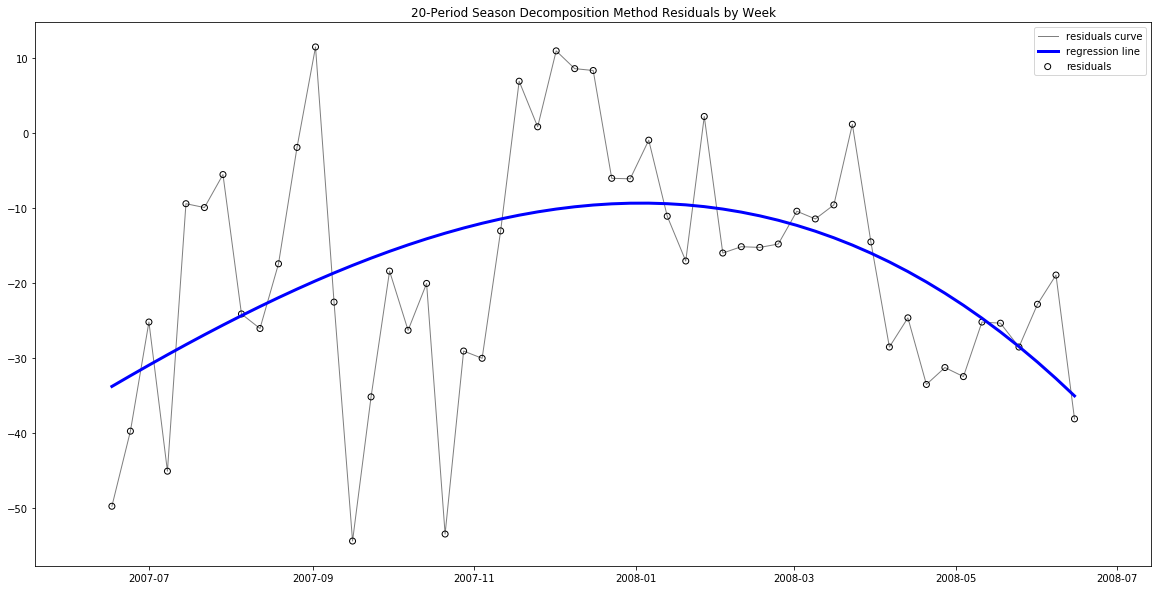

In [25]:
plt.figure(figsize=(20, 10))
plt.title('20-Period Season Decomposition Method Residuals by Week')
plt.scatter(my_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(my_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(my_df.index.values, decomp20_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

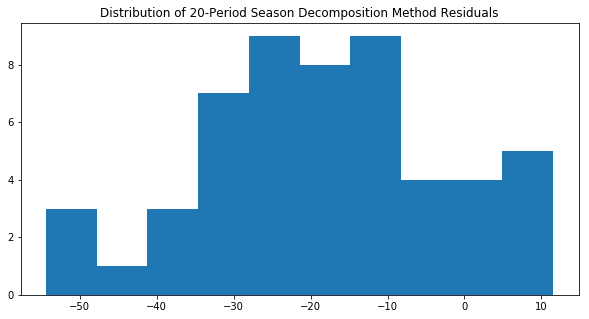

In [26]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of 20-Period Season Decomposition Method Residuals')
plt.hist(residuals)
plt.show()

In [27]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,17.037838,0.000037
1,2,22.271433,0.000015
2,3,23.997502,0.000025
3,4,24.683530,0.000058
4,5,26.513660,0.000071
5,6,26.784403,0.000159
6,7,27.106271,0.000319
7,8,29.604339,0.000248
8,9,33.101050,0.000128
9,10,34.021942,0.000183


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


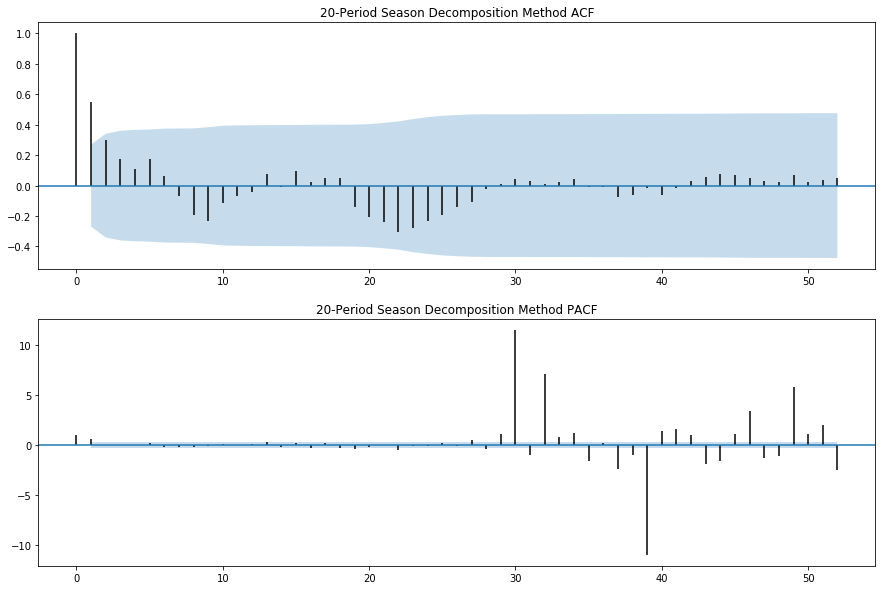

In [28]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, title='20-Period Season Decomposition Method ACF', marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, title='20-Period Season Decomposition Method PACF', marker=None)
plt.show()

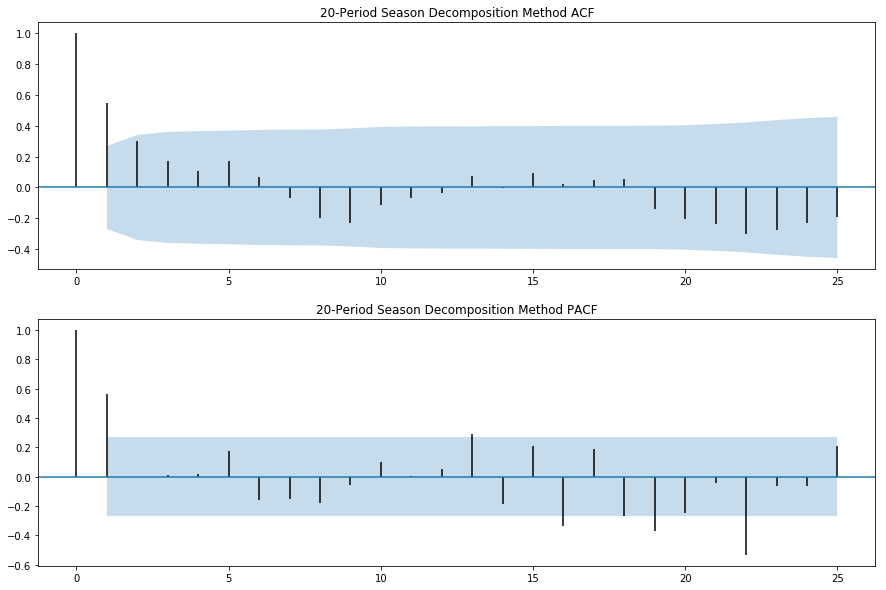

In [29]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, lags=25, title='20-Period Season Decomposition Method ACF', marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, lags=25, title='20-Period Season Decomposition Method PACF', marker=None)
plt.show()

The distribution of the residuals are not gaussian and there is autocorrelation in the residuals. The model fails to capture most of the variance in the data.